# Quickstart
Here is a quick demonstration of some of the main functionality of Invert4Geom. This assumes you are familar with Python and have [successfully installed](install.md) this packaged. See the [tutorials](tutorial/index.md) for a step-by-step introduction to Invert4Geom, and the [how-to guides](how_to/index.md) for more in-depth guides for specific features.

Import the various modules of Invert4Geom and a few other packages

In [1]:
from __future__ import annotations

import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import inversion, plotting, regional, synthetic, utils

# Load some synthetic gravity data

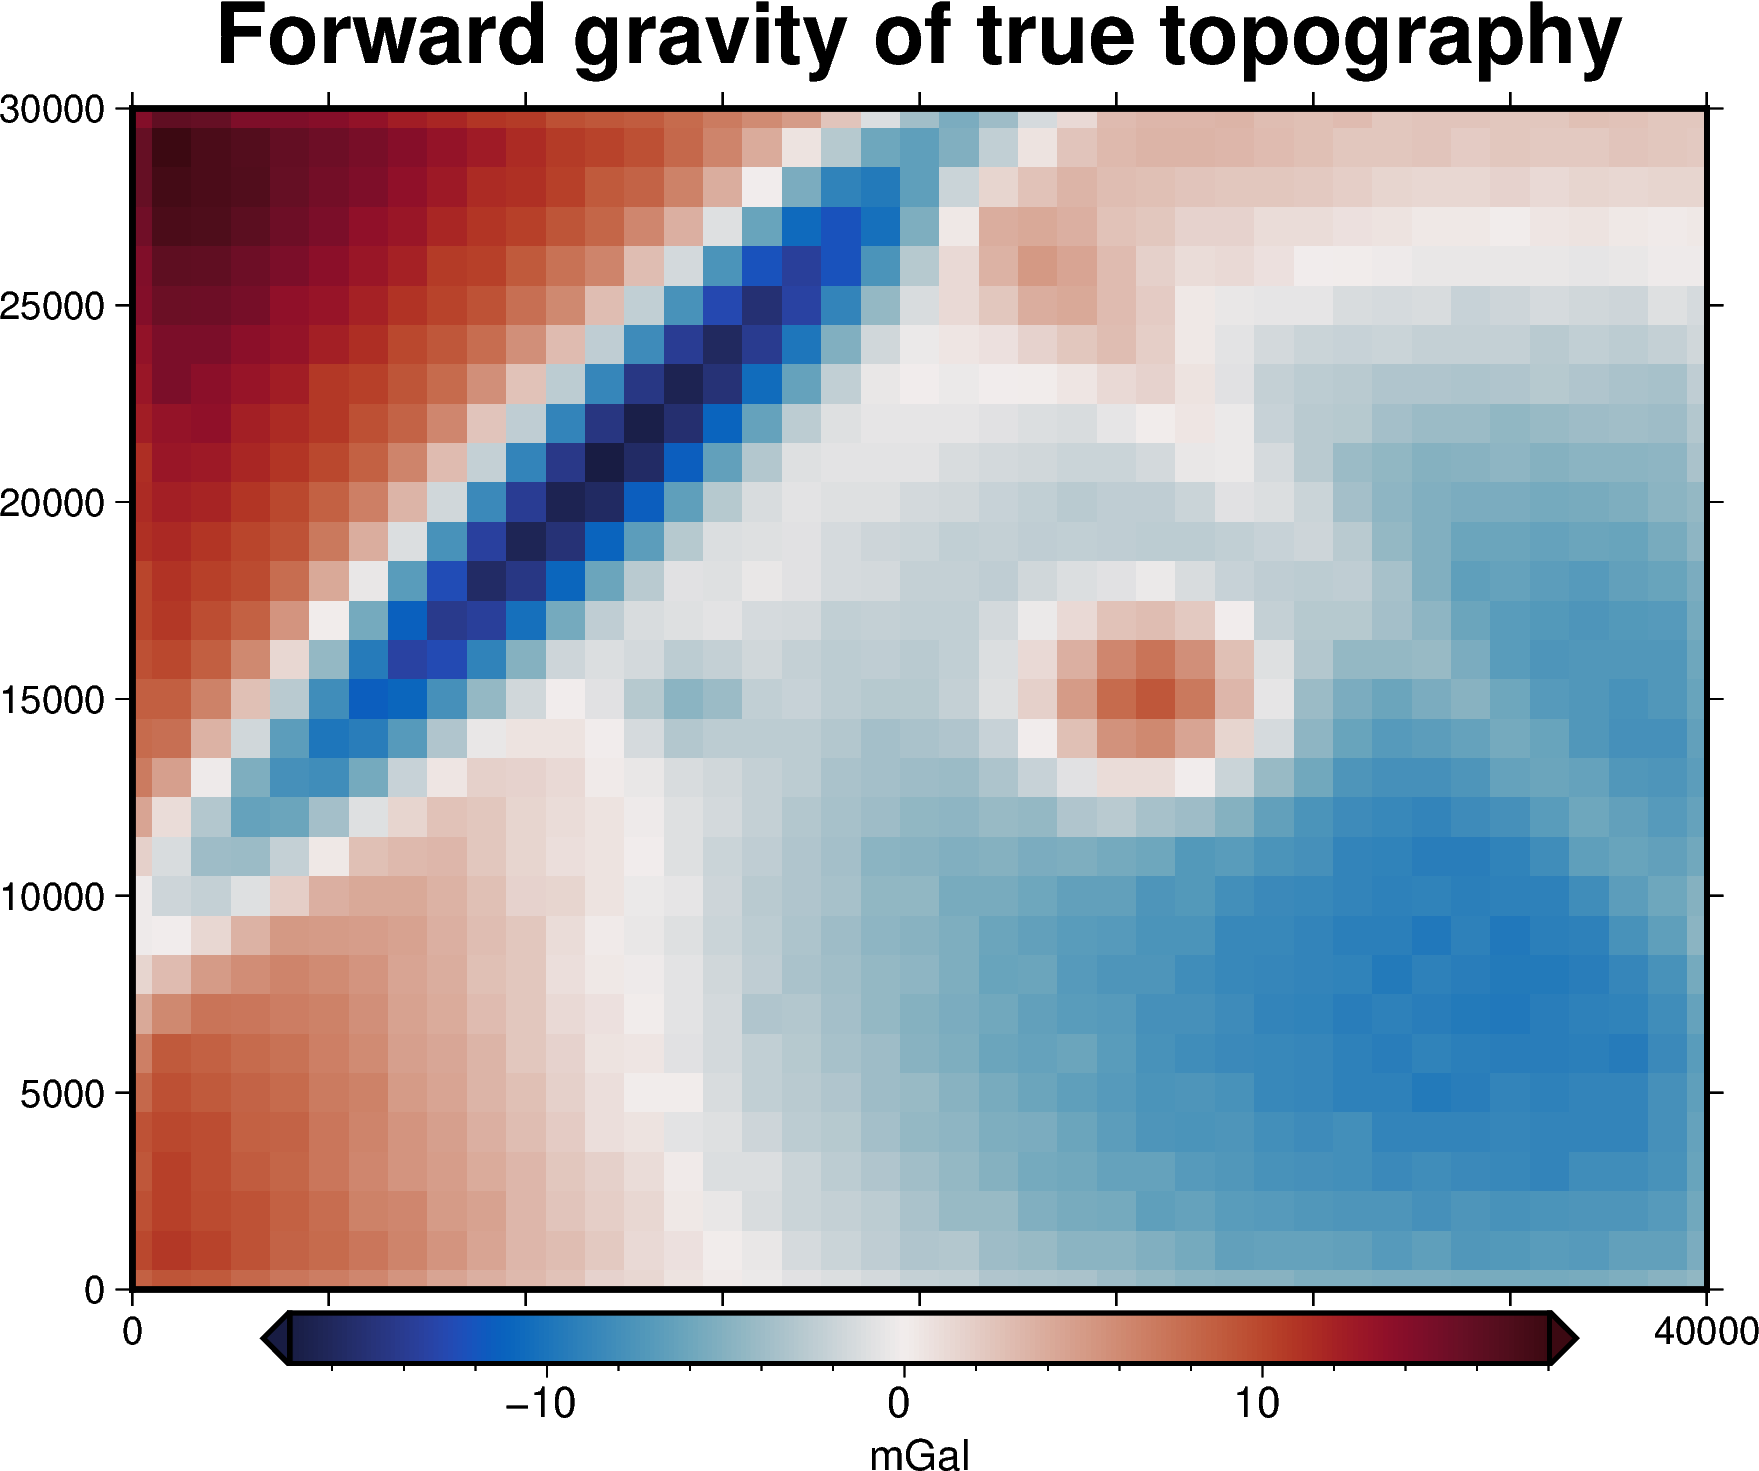

In [9]:
spacing = 1000
region = (0, 40000, 0, 30000)

true_density_contrast = 2500
true_zref = 500
true_topography, _, _, grav_df = synthetic.load_synthetic_model(
    spacing=spacing,
    region=region,
    density_contrast=true_density_contrast,
    zref=true_zref,
    gravity_noise=0.2,
)

# Create a starting model

In [19]:
# pick a density contrast (here we use the true value)
density_contrast = true_density_contrast

# pick a reference level (here we use the true value)
zref = true_zref

# create a flat surface at the reference level
starting_topography = xr.ones_like(true_topography) * zref

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

### Forward gravity of prism layer

In [20]:
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df.describe()

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,gravity_anomaly,starting_gravity,misfit,reg,res
count,1271.000000,1271.00000,1271.0,1271.000000,1271.0,1271.000000,1271.0,1271.000000
mean,15000.000000,20000.00000,1000.0,-0.868032,0.0,-0.868032,0.0,-0.868032
std,8947.792584,11836.81698,0.0,6.711459,0.0,6.711459,0.0,6.711459
min,0.000000,0.00000,1000.0,-17.191096,0.0,-17.191096,0.0,-17.191096
25%,7000.000000,10000.00000,1000.0,-5.954750,0.0,-5.954750,0.0,-5.954750
50%,15000.000000,20000.00000,1000.0,-1.789971,0.0,-1.789971,0.0,-1.789971
75%,23000.000000,30000.00000,1000.0,2.738258,0.0,2.738258,0.0,2.738258
max,30000.000000,40000.00000,1000.0,18.021414,0.0,18.021414,0.0,18.021414


## Gravity misfit
The gravity misfit is the difference between the observed gravity anomaly and the forward gravity of the starting topography. 

The misfit can be separated into regional and residual components, here we assume the regional component is 0.

In [21]:
grav_df = regional.regional_separation(
    method="constant",
    constant=0,
    grav_df=grav_df,
)

grav_df.describe()

,northing,easting,upward,gravity_anomaly,starting_gravity,misfit,reg,res
count,1271.000000,1271.00000,1271.0,1271.000000,1271.0,1271.000000,1271.0,1271.000000
mean,15000.000000,20000.00000,1000.0,-0.868032,0.0,-0.868032,0.0,-0.868032
std,8947.792584,11836.81698,0.0,6.711459,0.0,6.711459,0.0,6.711459
min,0.000000,0.00000,1000.0,-17.191096,0.0,-17.191096,0.0,-17.191096
25%,7000.000000,10000.00000,1000.0,-5.954750,0.0,-5.954750,0.0,-5.954750
50%,15000.000000,20000.00000,1000.0,-1.789971,0.0,-1.789971,0.0,-1.789971
75%,23000.000000,30000.00000,1000.0,2.738258,0.0,2.738258,0.0,2.738258
max,30000.000000,40000.00000,1000.0,18.021414,0.0,18.021414,0.0,18.021414


# Plot the gravity anomalies

makecpt [ERROR]: Option T: min >= max
makecpt [ERROR]: Option T: min >= max


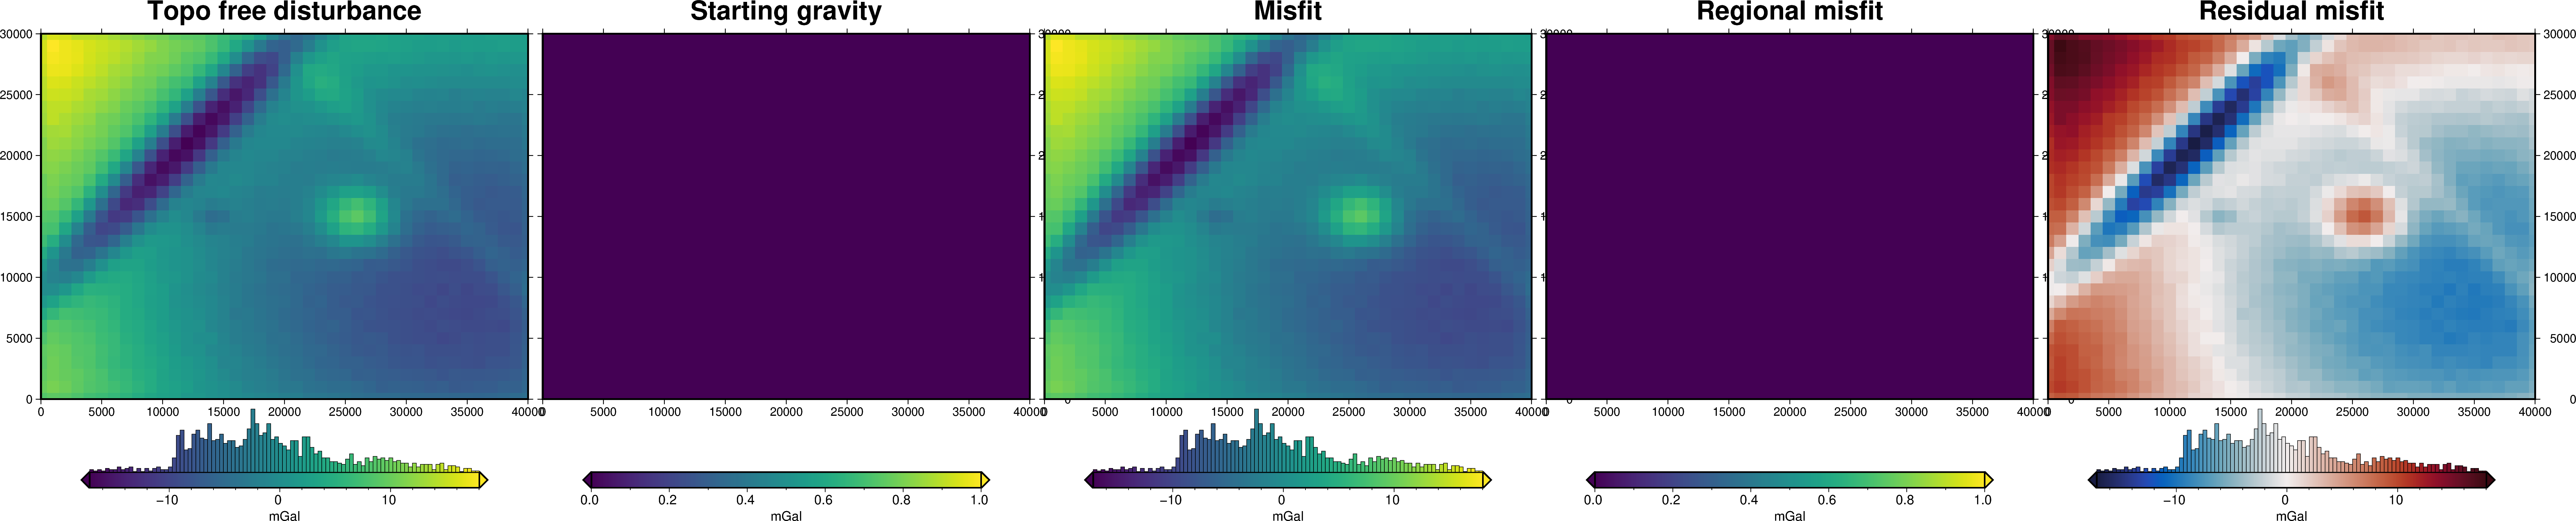

In [23]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    fig_height=10,
    title="Topo free disturbance",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.starting_gravity,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Starting gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)


fig = maps.plot_grd(
    grav_grid.misfit,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)
fig.show()

# Perform inversion
Now that we have a starting model and residual gravity misfit data we can start the inversion.

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

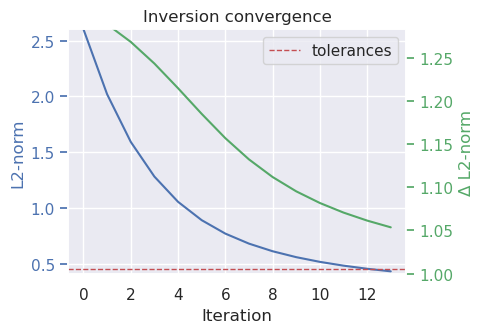

In [24]:
# run the inversion
results = inversion.run_inversion(
    grav_df=grav_df,
    prism_layer=starting_prisms,
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=200,
    l2_norm_tolerance=0.45,  # gravity error is .2 mGal, L2-norm is sqrt(mGal) so ~0.45
    delta_l2_norm_tolerance=1.005,
    plot_convergence=True,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

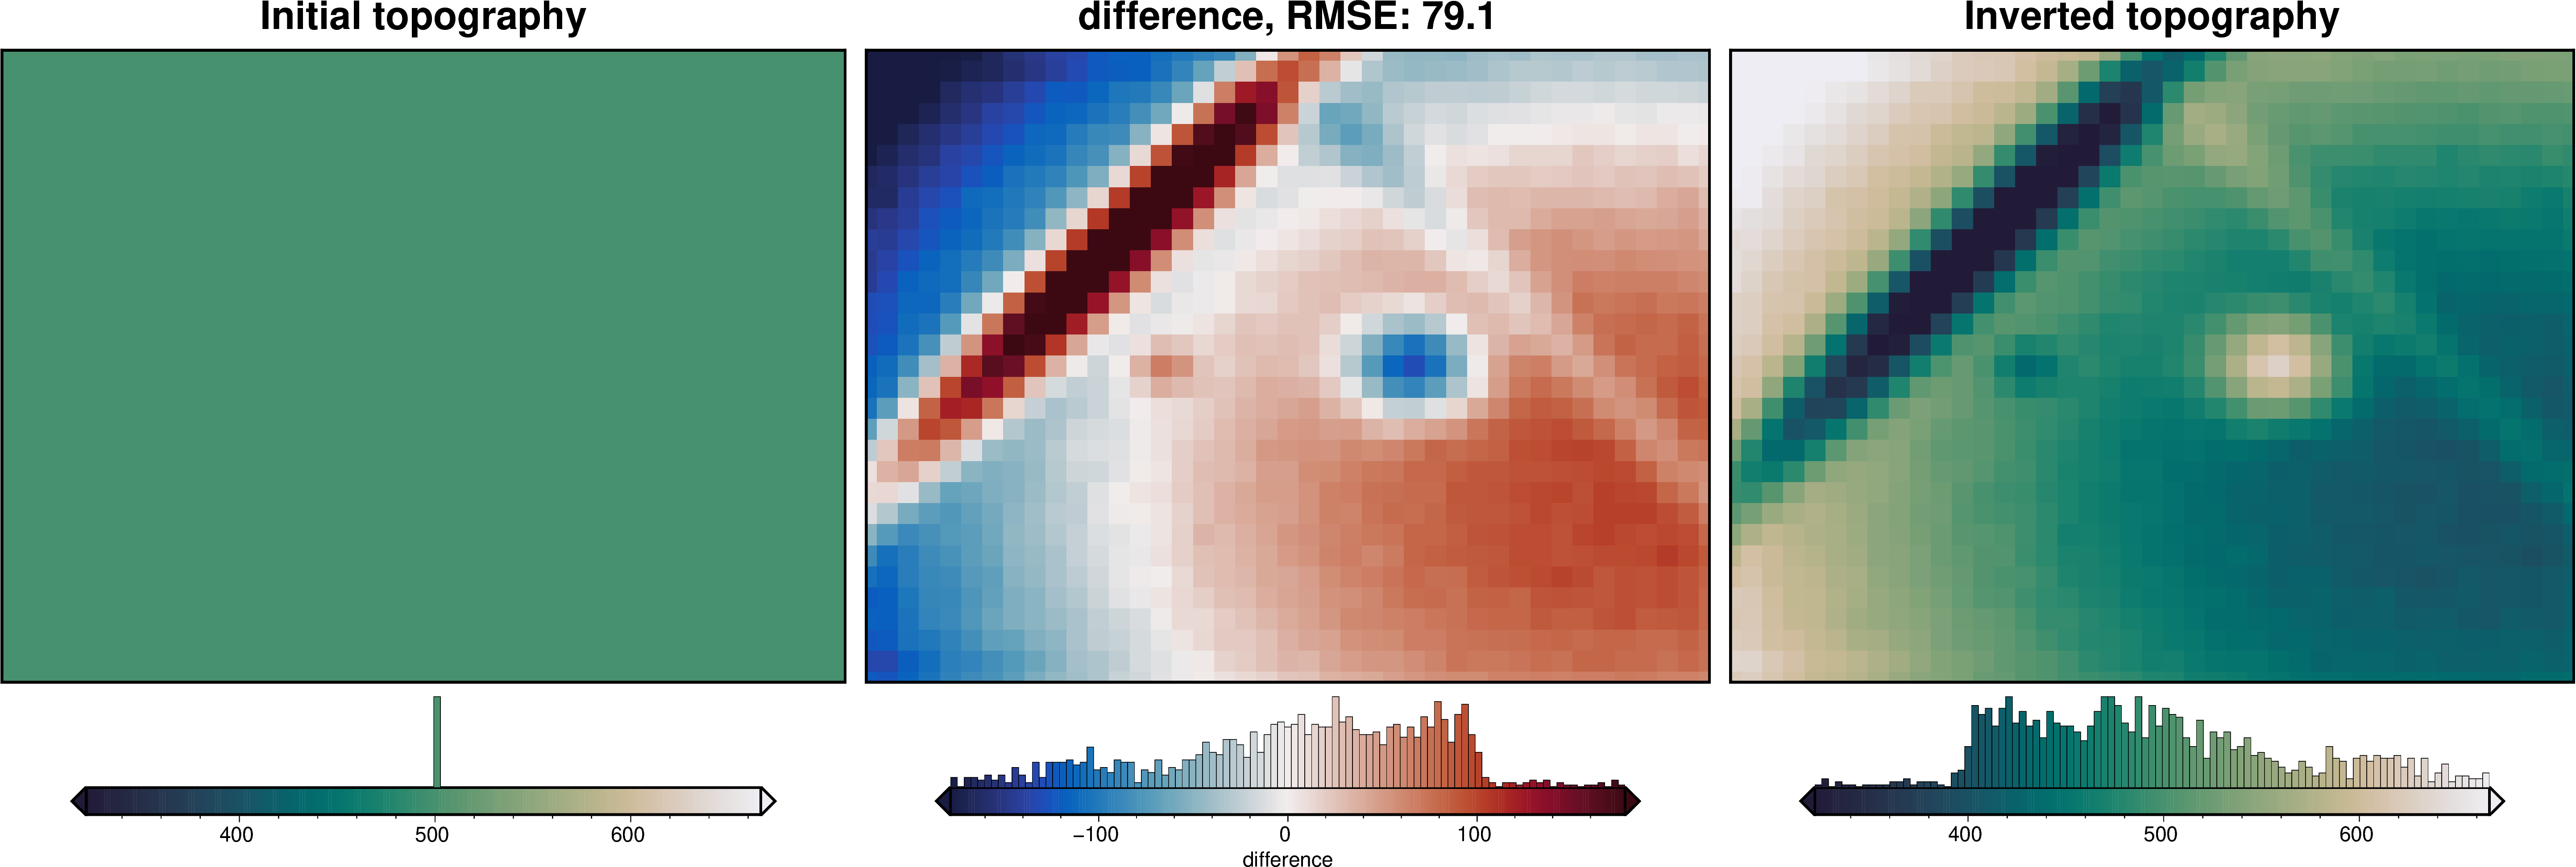

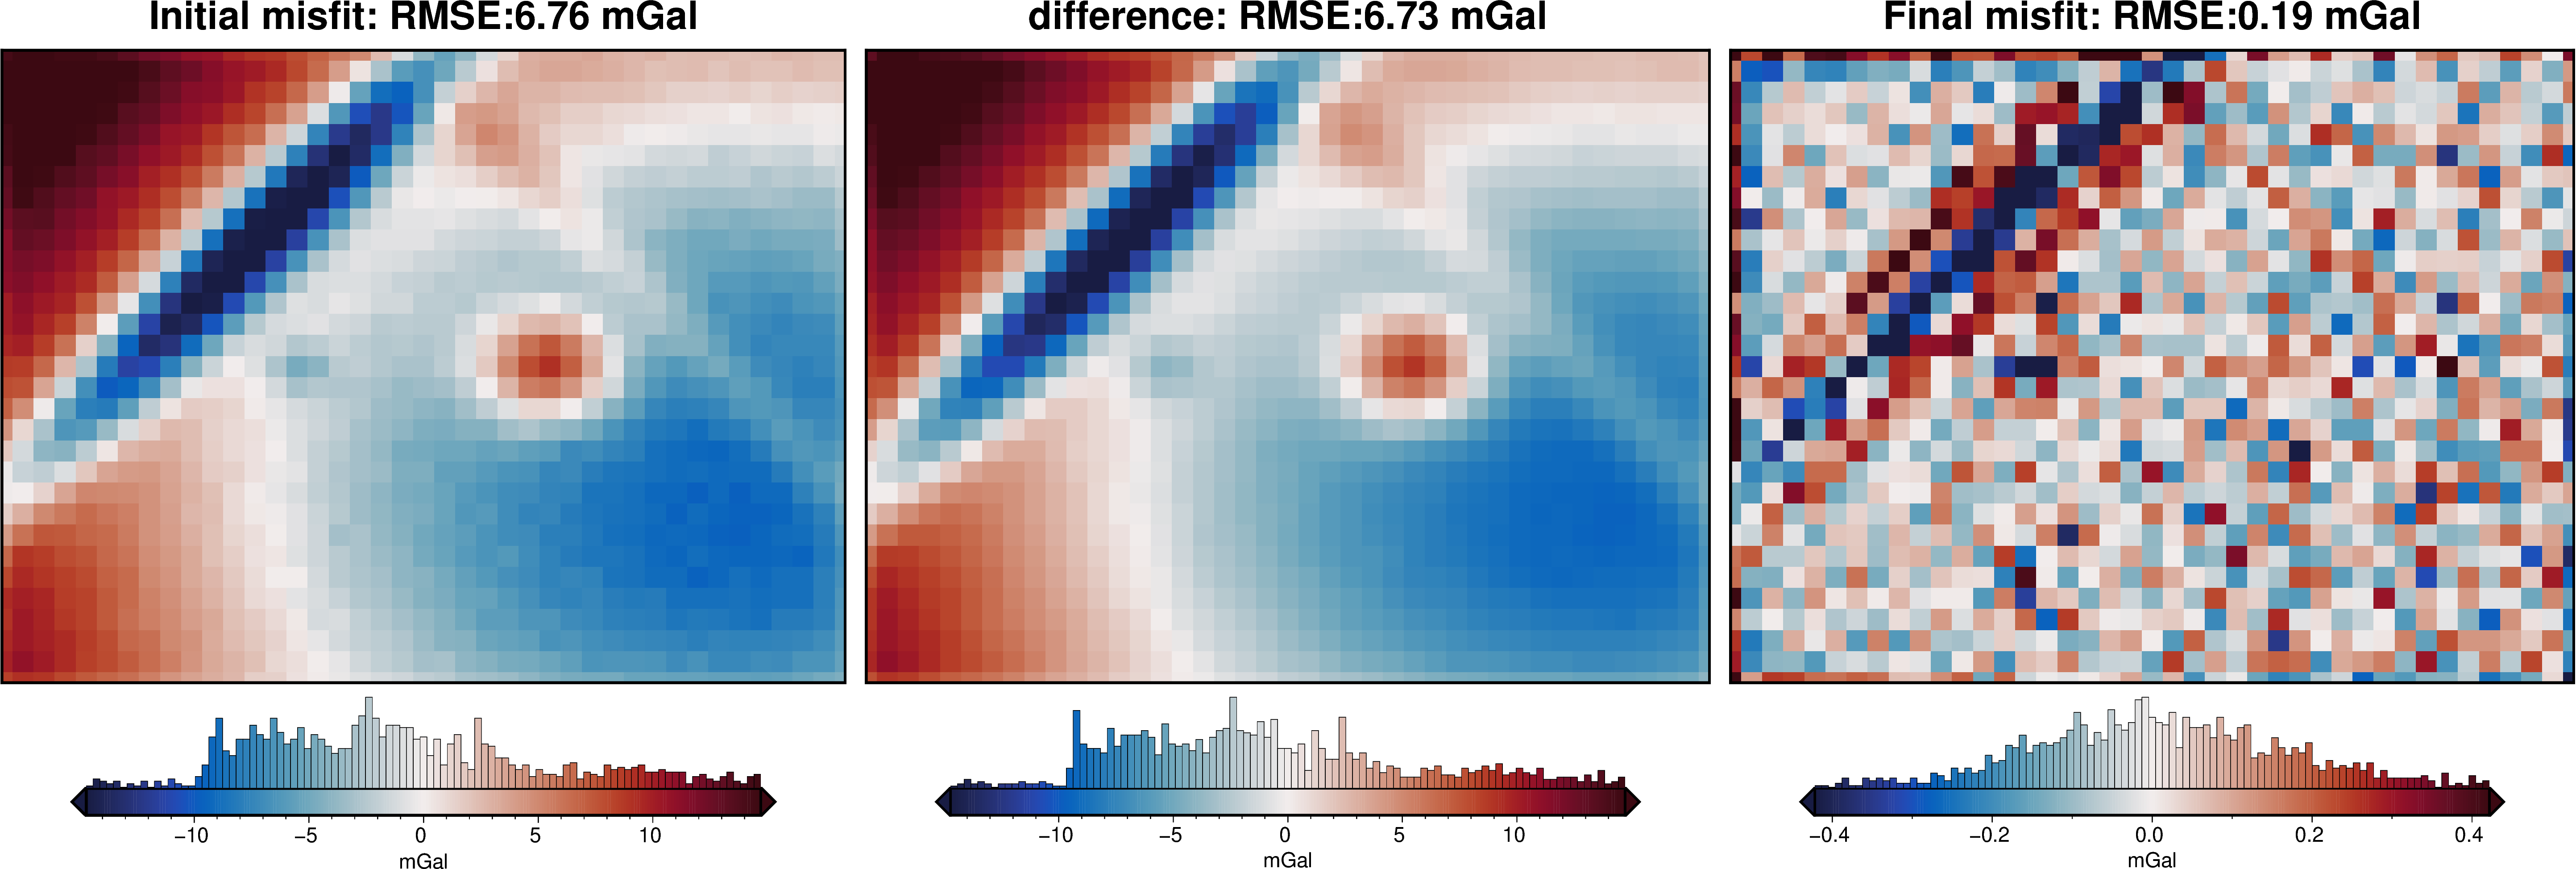

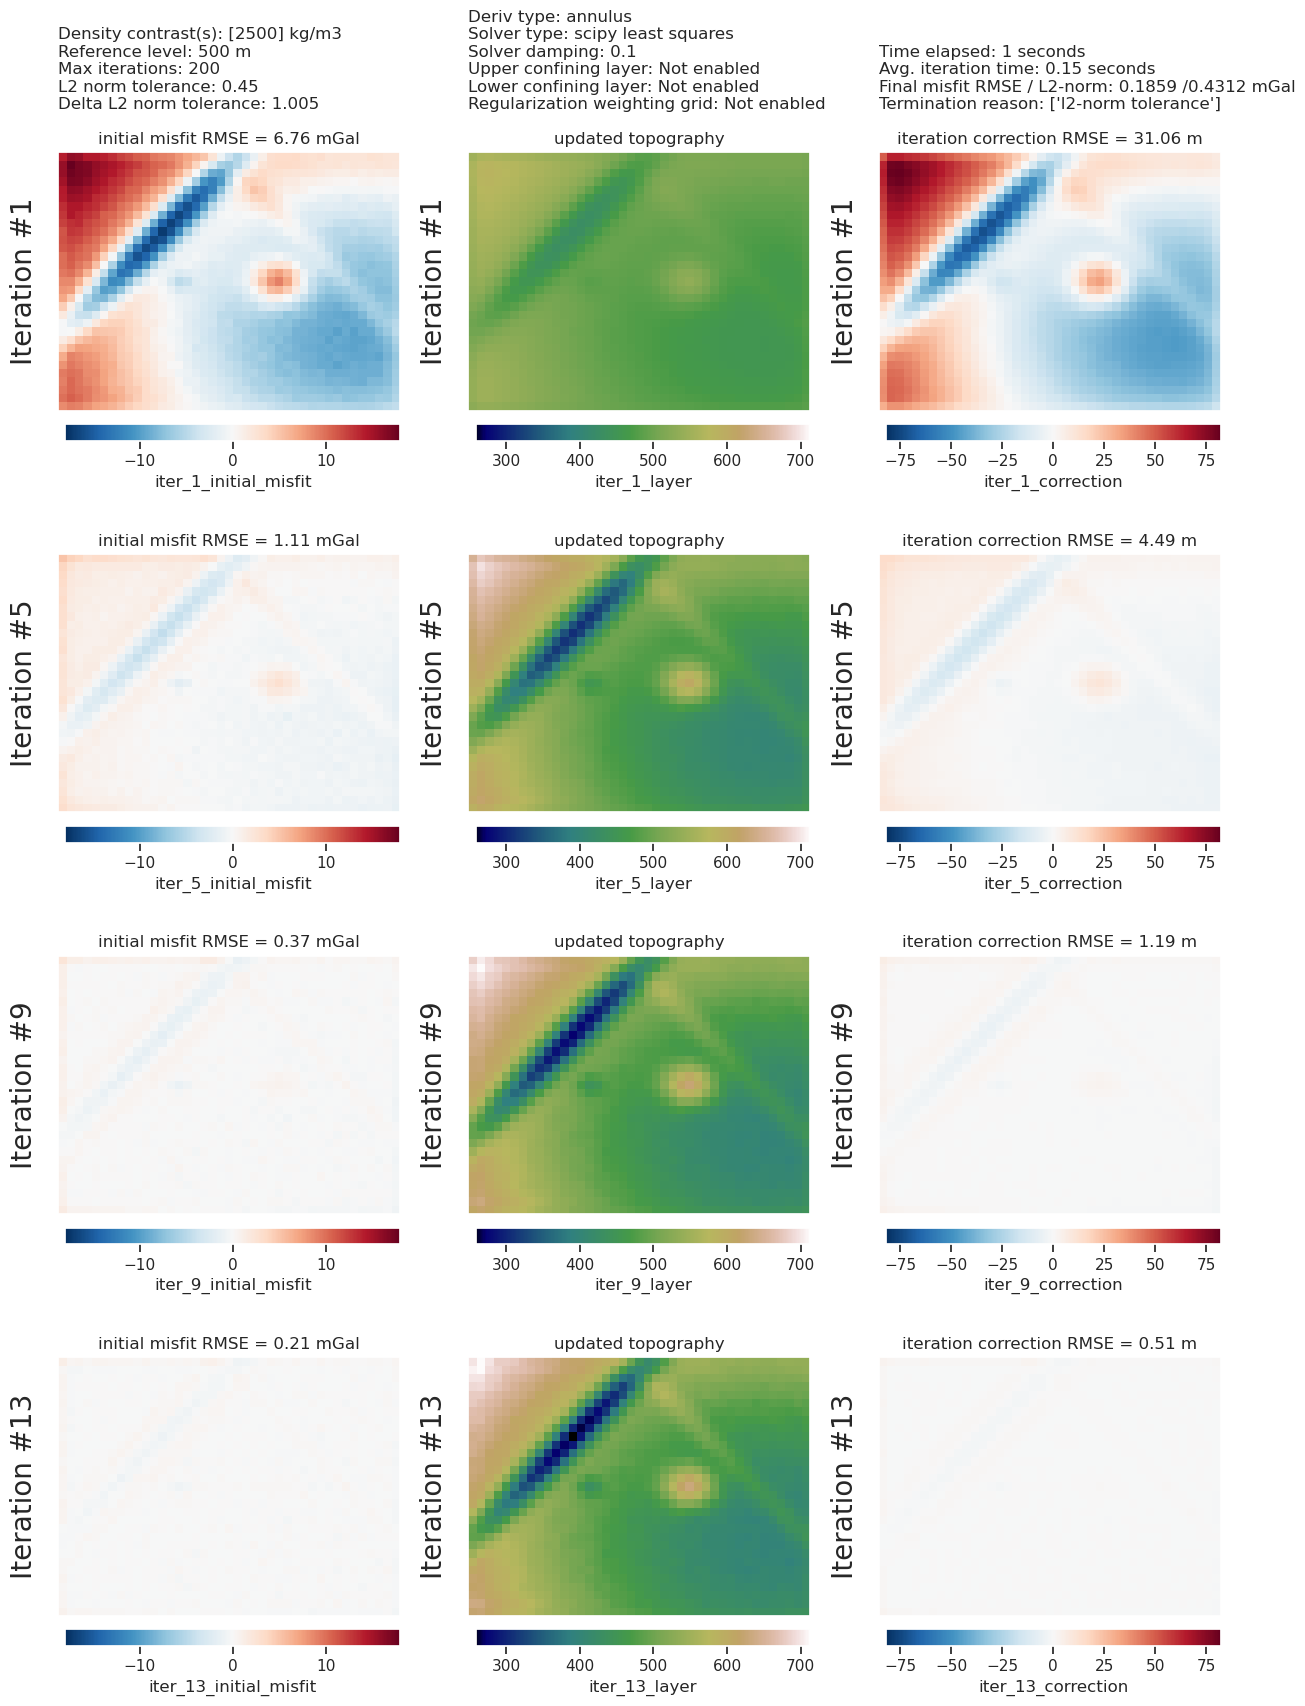

In [25]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=4,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

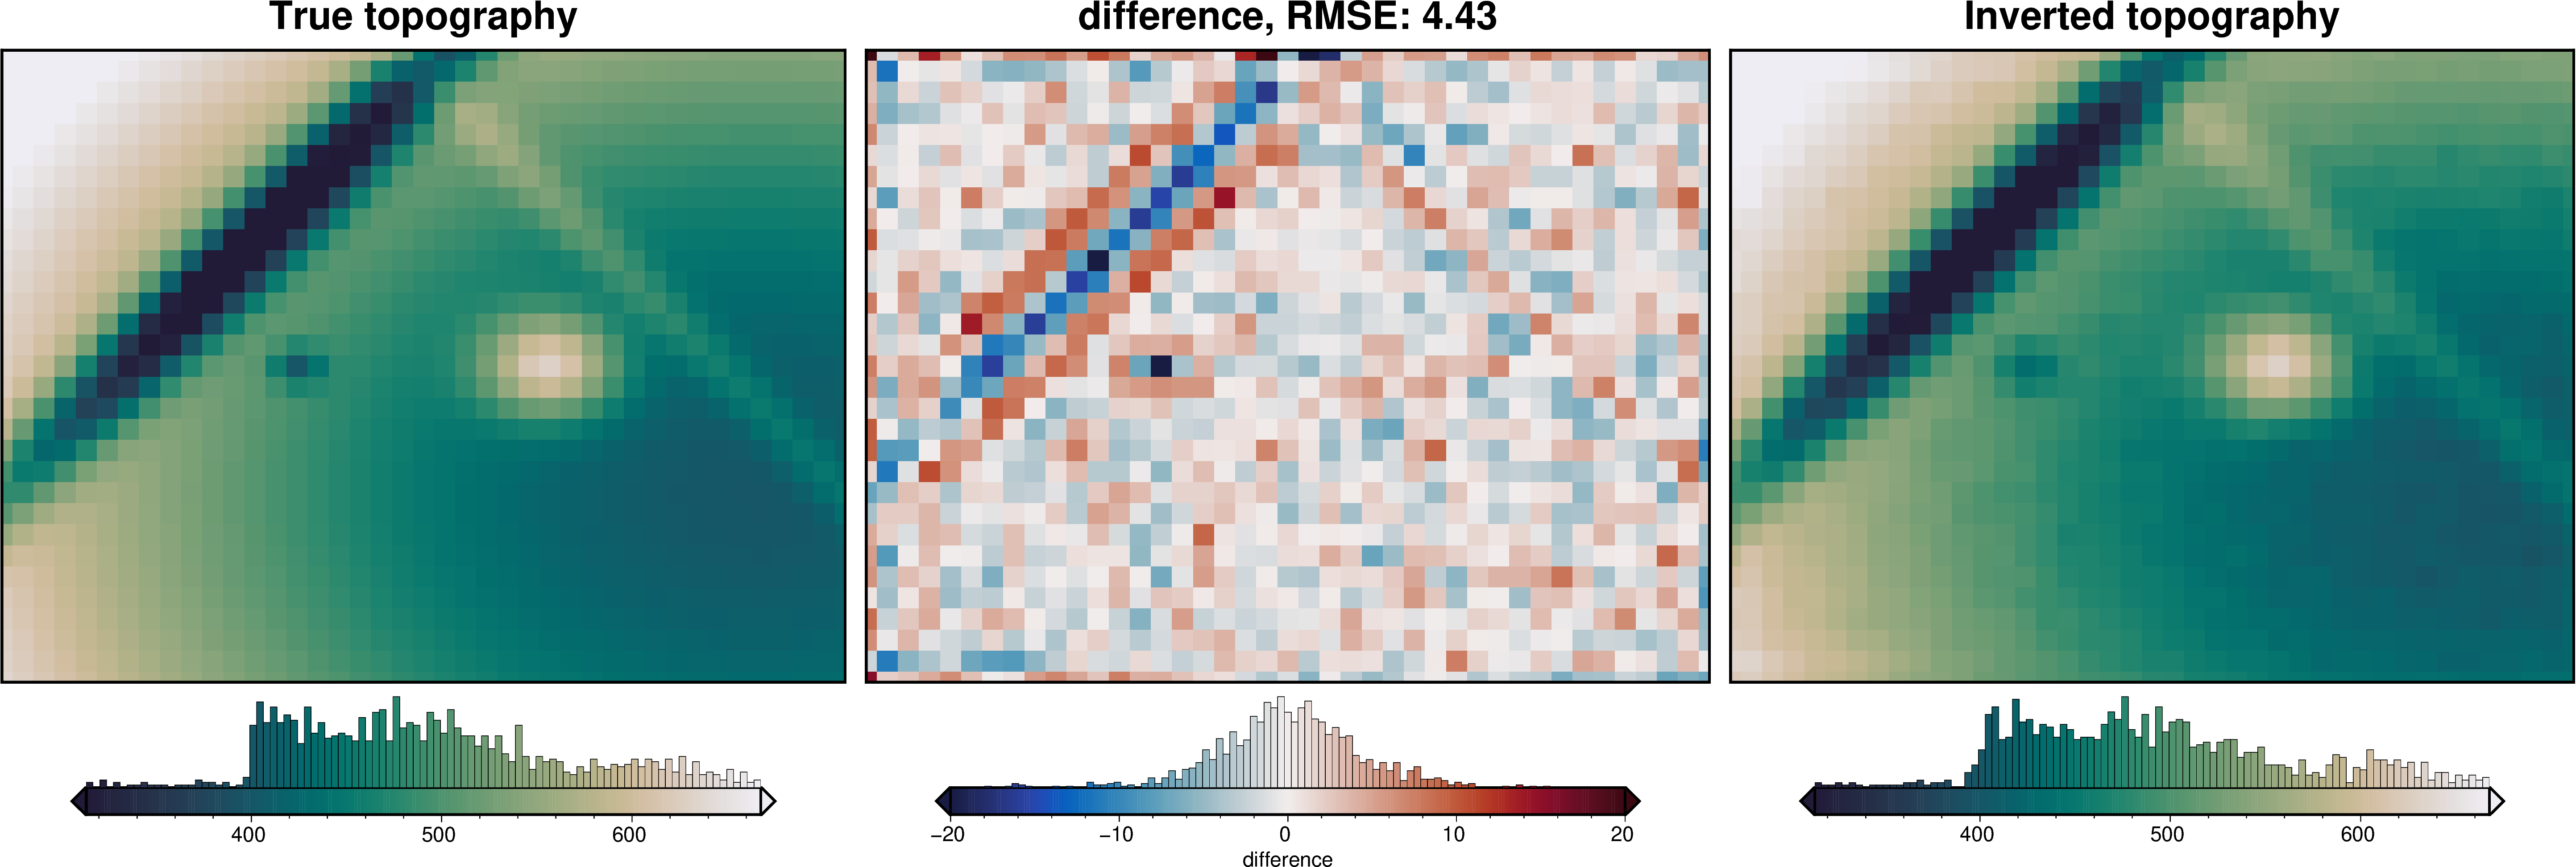

In [26]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    diff_lims=(-20, 20),
)

As you can see, the inversion successfully recovered the true topography. The root mean square difference between the true and recovered topography is low, but this is not too surprising since we gave the inversion the true density contrast and reference level values.